## Requirements

 - Operational System Windows, Linux or macOS
 - Python 3.6 or later
 - Jupyter notebook 5.7.8 or later

## Dependencies

#### Pandas

Library providing high-performance, easy-to-use data structures and data analysis tools.

Command install - pip install pandas

https://pandas.pydata.org/

#### NumPy

Package fundamental for manipulacion of data.

Command install - pip install numpy

https://www.numpy.org/

#### Matplotlib

Matplotlib is a Python 2D plotting library which produces publication.

Command install - pip install matplotlib

https://matplotlib.org/index.html

#### XGBoost

Contains models of classification based in Gradient Boosting.

Command install - pip install xgboost

https://github.com/dmlc/xgboost

#### MLxtend

Library for normalize data.

Command install - pip install mlxtend

https://github.com/rasbt/mlxtend

#### Scikit-learn

Simple and efficient tools for data mining and data analysis.

Command install - pip install scikit-learn

https://scikit-learn.org/stable/index.html

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, \
precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, precision_recall_curve, auc

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

## Helper Methods Section

In [2]:
def binary_converter(param):
    if param > 0:
        return 1
    else:
        return 0

In [3]:
def replace_negative_value(val):
    if(val < 0):
        return 0
    else:
        return val

In [4]:
def find_negative_columns_values(df):
    negative_columns = []

    for i, col in enumerate(df.columns):
        if ((df[col].dtypes != 'O') and df[col].min() < 0):
            negative_columns.append(col)
            
    return negative_columns

In [5]:
def replace_negative_values(val):
    if(val < 0):
        return 0
    else:
        return val

In [6]:
def show_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.title('ROC Curve')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [7]:
def show_precision_recall_curve(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    plt.title('Precision-Recall curve')
    plt.plot([0,1], [0.5, 0.5], linestyle='--')
    plt.plot(recall, precision, marker='.')
    plt.show()

In [8]:
def show_confusion_matrix(y_test, y_pred, figsize=(4,4)):
    
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, cmap='RdYlBu', fmt='.0f', annot=True)
    plt.show()

In [9]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [10]:
def show_metrics(y_true, y_test):
    
    accuracy = accuracy_score(y_true, y_test)
    precision = precision_score(y_true, y_test)
    recall = recall_score(y_true, y_test)
    f1 = f1_score(y_true, y_test)
    auc = roc_auc_score(y_true, y_test)
    mcc = matthews_corrcoef(y_true, y_test)
       
    print()
    print("accuracy:  %.5f" %accuracy)
    print("precision: %.5f" %precision)
    print("recall:    %.5f" %recall)
    print("f1:        %.5f" %f1)
    print("auc:       %.5f" %auc)
    print("mcc:       %.5f" %mcc)
    print()

In [11]:
def plot_pie_records(value1, value2, title, legend1='Without Accident', lengend2='With Accident'):
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

    recipe = [legend1, lengend2]

    data = [value1, value2]
    labels = [x for x in recipe]
    explode = (0.1,0.001)

    def func(pct, allvals):
        absolute = pct/100.*np.sum(allvals)
        return "{:.0f}%\n {}".format(pct, np.int(absolute))

    wedges, texts, autotexts = ax.pie(data, explode=explode, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), startangle=75, shadow=True)

    ax.legend(wedges, labels,
              title="Records",
              loc="center left",
              bbox_to_anchor=(1, 0))

    plt.setp(autotexts, size=16, weight="bold")

    ax.set_title(title, fontsize=17, fontweight='bold')

    plt.show()

In [12]:
def scatter_pca(xtrain, ytrain, title):
    pca = PCA(n_components=2) 

    X = pca.fit_transform(xtrain)
    y = ytrain.copy()
    
    dt = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'red', 1:'blue'}
    fig, ax = plt.subplots()
    grouped = dt.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    
    plt.title(title)
    plt.show()

## Loading the dataset

In [13]:
dataset = pd.read_csv('base.csv', encoding='ISO-8859-1', sep=';')

In [14]:
dataset['QTD_TRI_FAI'] = dataset['QTD_TRI'] + dataset['QTD_FAI']

In [15]:
dataset['HOUVE_TRI_FAI'] = dataset['QTD_TRI_FAI'].apply(binary_converter)

In [16]:
dataset.drop(['QTD_TRI', 'QTD_FAI', 'QTD_TRI_FAI'], axis=1, inplace=True)

In [17]:
len(dataset.columns)

135

### Exploraty Data Analysis

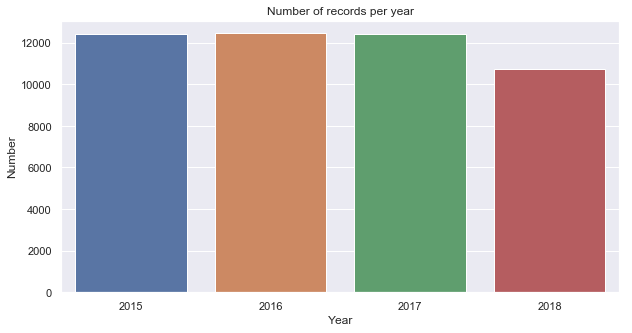

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataset, x='Ano')
plt.title("Number of records per year")
plt.xlabel('Year')
plt.ylabel('Number')
plt.show()

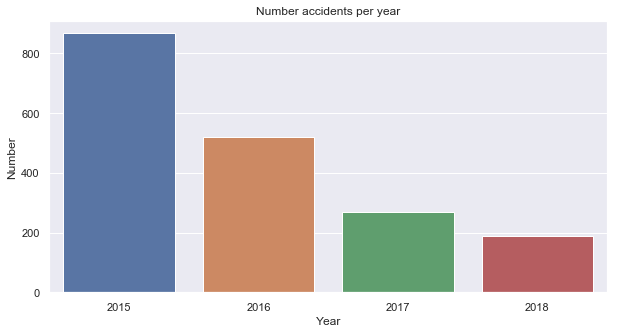

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataset[dataset.HOUVE_TRI_FAI == 1], x='Ano')
plt.title("Number accidents per year")
plt.xlabel('Year')
plt.ylabel('Number')
plt.show()

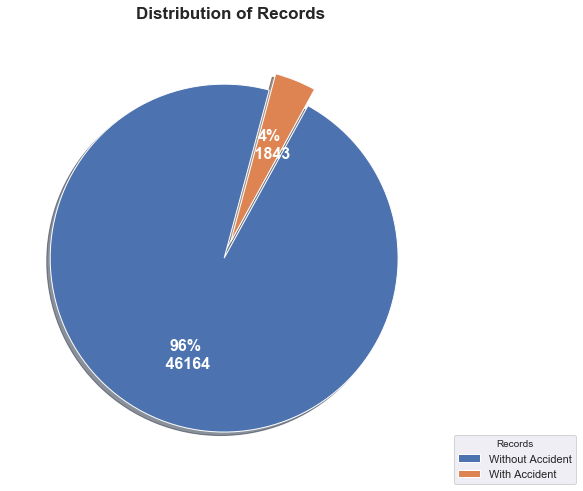

In [20]:
withoutAccident =  dataset.HOUVE_TRI_FAI.value_counts()[0]
withAccident =  dataset.HOUVE_TRI_FAI.value_counts()[1]

plot_pie_records(withoutAccident, withAccident, "Distribution of Records")

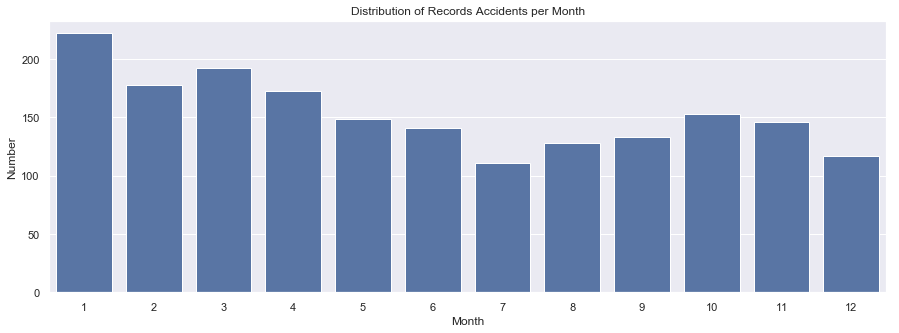

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(data=dataset[dataset.HOUVE_TRI_FAI == 1], x='Mes', color='b')
plt.title("Distribution of Records Accidents per Month")
plt.ylabel('Number')
plt.xlabel('Month')
plt.show()

### Removing Quiz Features

In [22]:
quiz_features = [col for col in dataset.columns if 'Q' in col and col[-1].isdigit()]

In [23]:
print(list(quiz_features))

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 'Q55', 'Q56', 'Q57', 'Q58', 'Q59', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q70', 'Q71', 'Q72', 'Q73', 'Q74']


In [24]:
dataset.drop(labels=quiz_features, axis=1, inplace=True)

In [25]:
len(dataset.columns)

61

### Removing QTD_TRI_FAI

At some point this feature is highly correlated to the response variable that's why we should talk to ambev's team to undestand it better

In [26]:
dataset.drop(['QTD_FAI_15_dias_antes'], axis=1, inplace=True)

# Feature engineering

### Categorical features

In [27]:
categorical_vars = [var for var in dataset.columns if dataset[var].dtypes=='O']

print('Number of categorical variables: ', len(categorical_vars))

Number of categorical variables:  4


### Number of each different categorical category

In [28]:
for var in categorical_vars:
    print(var, dataset[var].unique(), ' categories')
    print()

Data ['01/01/2015' '02/01/2015' '03/01/2015' ... '09/11/2018' '10/11/2018'
 '11/11/2018']  categories

Unidade ['Brewery A' 'Brewery B' 'Brewery C' 'Brewery D' 'Brewery E' 'Brewery F'
 'Brewery G' 'Brewery H' 'Brewery I' 'Brewery J' 'Brewery K' 'Brewery L'
 'Brewery M' 'Brewery N' 'Brewery O' 'Brewery P' 'Brewery Q' 'Brewery AA'
 'Brewery BB' 'Brewery CC' 'Brewery DD' 'Brewery EE' 'Brewery FF'
 'Brewery GG' 'Brewery HH' 'Brewery II' 'Brewery JJ' 'Brewery KK'
 'Brewery MM' 'Brewery NN' 'Brewery OO' 'Brewery PP' 'Brewery QQ']  categories

Cidade ['Cidade 01' 'Cidade 02' 'Cidade 03' 'Cidade 04' 'Cidade 05' 'Cidade 06'
 'Cidade 07' 'Cidade 08' 'Cidade 09' 'Cidade 10' 'Cidade 11' 'Cidade 12'
 'Cidade 13' 'Cidade 14' 'Cidade 15' 'Cidade 16' 'Cidade 17' 'Cidade 18'
 'Cidade 19' 'Cidade 20' 'Cidade 21' 'Cidade 22' 'Cidade 23' 'Cidade 24'
 'Cidade 25' 'Cidade 26' 'Cidade 27' 'Cidade 28' 'Cidade 29']  categories

Cidade_Clima ['Cidade Clima 01' 'Cidade Clima 02' 'Cidade Clima 03' 'Cidade Clima 0

Missing values

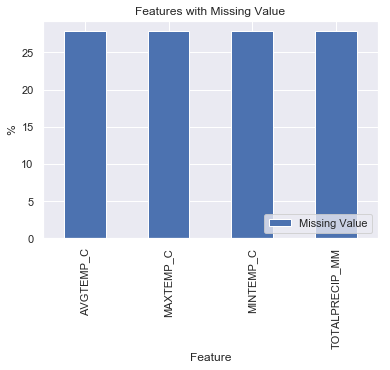

In [29]:
dfMve =  pd.DataFrame(data=np.column_stack((dataset.columns, np.array(dataset.isnull().sum() / len(dataset) * 100))), columns=['Feature', 'Missing Value'])

bar = dfMve[dfMve['Missing Value'] > 0].set_index('Feature').plot(kind='bar')
bar.set_title('Features with Missing Value')
bar.legend(loc='lower right')
plt.ylabel('%')
plt.show()

In [30]:
#'Data', 'Ano', 'Unidade', 'Cidade', 'Cidade_Clima'
labelEncoder = LabelEncoder()
dataset['Data'] = labelEncoder.fit_transform(dataset['Data'])
dataset['Ano'] = labelEncoder.fit_transform(dataset['Ano'])
dataset['Unidade'] = labelEncoder.fit_transform(dataset['Unidade'])
dataset['Cidade'] = labelEncoder.fit_transform(dataset['Cidade'])
dataset['Cidade_Clima'] = labelEncoder.fit_transform(dataset['Cidade_Clima']) 

In [31]:
dfTempCidade = dataset.groupby('Cidade')[['MINTEMP_C','MAXTEMP_C', 'AVGTEMP_C']].mean().reset_index()

for cidade in range(len(dfTempCidade.index)):
    rowCidade = dfTempCidade[dfTempCidade.Cidade == cidade]
    replaceValues = {'MINTEMP_C': rowCidade.MINTEMP_C.values[0],
                     'MAXTEMP_C': rowCidade.MAXTEMP_C.values[0],
                     'AVGTEMP_C': rowCidade.AVGTEMP_C.values[0]}

    dataset.loc[dataset.Cidade == cidade] = dataset.loc[dataset.Cidade == cidade].fillna(replaceValues)

In [32]:
dataset['TOTALPRECIP_MM'].fillna(0, inplace=True)

### Features with negative values

In [33]:
negative_columns = find_negative_columns_values(dataset)

In [34]:
print(list(negative_columns))

['Parada_Automacao', 'Parada_Eletrica', 'Parada_HSMO', 'Parada_Instrumentacao', 'Parada_Mecanica', 'Parada_Operacional', 'Parada_Programada', 'Parada_Qualidade', 'Parada_Suprimentos', 'total_paradas', 'MINTEMP_C']


### As temperatures can have negative values we simply ignore MINTEMP_C column

In [35]:
negative_columns.remove('MINTEMP_C')

In [36]:
print(list(negative_columns))

['Parada_Automacao', 'Parada_Eletrica', 'Parada_HSMO', 'Parada_Instrumentacao', 'Parada_Mecanica', 'Parada_Operacional', 'Parada_Programada', 'Parada_Qualidade', 'Parada_Suprimentos', 'total_paradas']


In [37]:
for col in negative_columns:
    dataset[col] = dataset[col].apply(lambda x: replace_negative_values(x))

# Feature Scaling

In [38]:
scaler = MinMaxScaler() 
df_columns = dataset.columns

scaler.fit(dataset) 

df_columns = dataset.columns

df_scaled = pd.DataFrame(scaler.transform(dataset), columns=df_columns)

dataset = df_scaled.copy()

In [39]:
dataset.head()

,Data,Ano,Mes,Sem,Unidade,ID_UNIDADE,QLP,Altura,Atencao_Postural,Celular,Eletricidade,EPI,Equipamento_de_Elevacao,Espaco_Confinado,LOTO,Manuseio_de_Vidro,Piso_Molhado,PT,Quimicos,SAM,Transporte,Indefinido,Atos_inseguros_no_dia,Atos_inseguros_15_dias_antes,Atos_inseguros_30_dias_antes,Atos_inseguros_45_dias_antes,incidentes_no_dia,incidentes_em_15_dias,incidentes_em_30_dias,incidentes_em_45_dias,abordagens_positivas,abordagens_positivas_15_dias_antes,abordagens_positivas_30_dias_antes,abordagens_positivas_45_dias_antes,Turnover,Horas_Excedentes,Interjornadas,Cidade,Cidade_Clima,Volume_prod,Parada_Automacao,Parada_Eletrica,Parada_HSMO,Parada_Instrumentacao,Parada_Logistica,Parada_Mecanica,Parada_Operacional,Parada_Processo,Parada_Programada,Parada_Qualidade,Parada_Suprimentos,Parada_Utilidades,total_paradas,QTD_FAI_30_dias_antes,QTD_FAI_45_dias_antes,AVGTEMP_C,MAXTEMP_C,MINTEMP_C,TOTALPRECIP_MM,HOUVE_TRI_FAI
0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.845570,0.770701,0.833753,0.025161,0.0
1,0.033333,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.860759,0.798301,0.828715,0.005851,0.0
2,0.066667,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.870886,0.783439,0.846348,0.003511,0.0
3,0.100000,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.858228,0.781316,0.788413,0.016384,0.0
4,0.133333,0.0,0.0,0.0,0.0,0.111111,0.022772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.787342,0.702760,0.793451,0.035693,0.0


### Train Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(labels=['HOUVE_TRI_FAI'], axis=1), 
                                                    dataset[['HOUVE_TRI_FAI']], 
                                                    test_size=0.2, 
                                                    random_state=0)

X_train.shape, X_test.shape

((38406, 59), (9602, 59))

# Feature Selection

### Removing constant features

The code below removes all features which variance doesn’t meet some threshold (in this case, zero)

In [41]:
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

In [42]:
constant_features

['Indefinido']

In [43]:
X_train['Indefinido'].unique()

array([0.])

In [44]:
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((38406, 58), (9602, 58))

### Removing quasi constant features
The code below removes all features which variance does not meet some threshold (in this case, almost 98%)

In [45]:
quasi_constant_feat = []
for feature in X_train.columns:

    # find the predominant value
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate predominant feature
    if predominant > 0.98:
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

4

In [46]:
print(list(quasi_constant_feat))

['Equipamento_de_Elevacao', 'Espaco_Confinado', 'PT', 'Turnover']


In [47]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((38406, 54), (9602, 54))

### Recursive Feature Selection

In [48]:
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=400))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

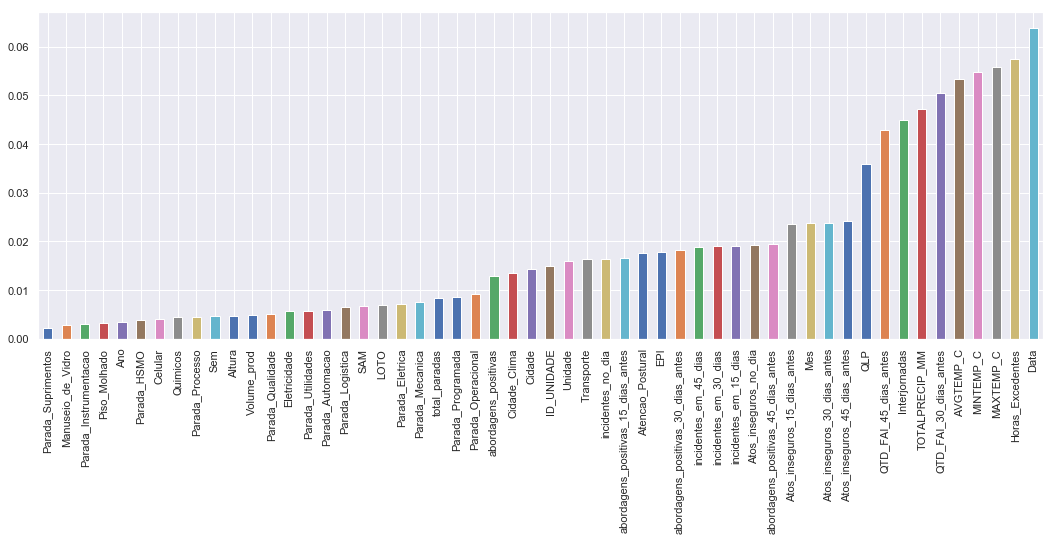

In [49]:
#ranking each feature from the least to the most important
features = pd.Series(sel_.estimator_.feature_importances_)
features.index = X_train.columns

features.sort_values(ascending=True, inplace=True)

features.plot.bar(figsize=(18,6))

In [50]:
# let's make a list and count the selected features
selected_feat = X_train.columns[(sel_.get_support())]

print('Features to keep')
print()
for i, col in enumerate(selected_feat):
    print(str(i+1).zfill(2), col)

Features to keep

01 Data
02 Mes
03 QLP
04 Atos_inseguros_no_dia
05 Atos_inseguros_15_dias_antes
06 Atos_inseguros_30_dias_antes
07 Atos_inseguros_45_dias_antes
08 incidentes_em_15_dias
09 incidentes_em_30_dias
10 incidentes_em_45_dias
11 abordagens_positivas_45_dias_antes
12 Horas_Excedentes
13 Interjornadas
14 QTD_FAI_30_dias_antes
15 QTD_FAI_45_dias_antes
16 AVGTEMP_C
17 MAXTEMP_C
18 MINTEMP_C
19 TOTALPRECIP_MM


In [51]:
features_to_remove = [col for col in X_train.columns if col not in selected_feat]

print('Features to remove')
print()
for i, col in enumerate(features_to_remove):
    print(str(i+1).zfill(2), col)

Features to remove

01 Ano
02 Sem
03 Unidade
04 ID_UNIDADE
05 Altura
06 Atencao_Postural
07 Celular
08 Eletricidade
09 EPI
10 LOTO
11 Manuseio_de_Vidro
12 Piso_Molhado
13 Quimicos
14 SAM
15 Transporte
16 incidentes_no_dia
17 abordagens_positivas
18 abordagens_positivas_15_dias_antes
19 abordagens_positivas_30_dias_antes
20 Cidade
21 Cidade_Clima
22 Volume_prod
23 Parada_Automacao
24 Parada_Eletrica
25 Parada_HSMO
26 Parada_Instrumentacao
27 Parada_Logistica
28 Parada_Mecanica
29 Parada_Operacional
30 Parada_Processo
31 Parada_Programada
32 Parada_Qualidade
33 Parada_Suprimentos
34 Parada_Utilidades
35 total_paradas


In [52]:
X_train.drop(labels=features_to_remove, axis=1, inplace=True)
X_test.drop(labels=features_to_remove, axis=1, inplace=True)

In [53]:
len(X_train.columns)

19

### Removing features using univariate roc_auc

In [54]:
# find important features using univariate roc-auc

# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set
roc_values = []
for feature in X_train.columns:
    clf = RandomForestClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

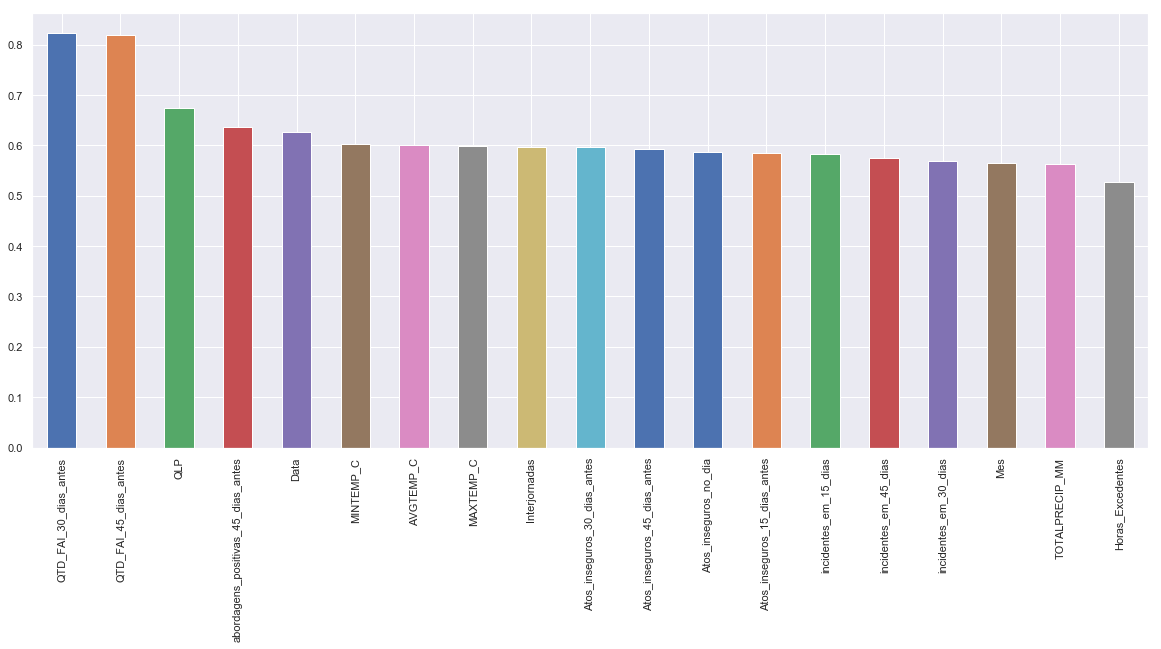

In [55]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [56]:
# by removing features with univariate roc_auc == 0.5
selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

deleted_feat = roc_values[roc_values <= 0.5]
deleted_feat

Series([], dtype: float64)

In [57]:
X_train.drop(labels=deleted_feat.index, axis=1, inplace=True)
X_test.drop(labels=deleted_feat.index, axis=1, inplace=True)

In [58]:
len(X_train.columns)

19

### Removing correlated features

Correlation predictor variables provide redundant information

Variables should be correlated with the target but uncorrelated among themselves

In [59]:
# with the following function we can select highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

I chose to eliminate features under Pearson Correlation 0.8 mark

In [60]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

9

In [61]:
print(corr_features)

{'incidentes_em_30_dias', 'Atos_inseguros_15_dias_antes', 'MAXTEMP_C', 'incidentes_em_45_dias', 'QTD_FAI_45_dias_antes', 'Atos_inseguros_45_dias_antes', 'MINTEMP_C', 'Atos_inseguros_30_dias_antes', 'incidentes_em_15_dias'}


In [62]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

In [63]:
len(X_train.columns)

10

Features Selected

In [64]:
X_train.columns

Index(['Data', 'Mes', 'QLP', 'Atos_inseguros_no_dia',
       'abordagens_positivas_45_dias_antes', 'Horas_Excedentes',
       'Interjornadas', 'QTD_FAI_30_dias_antes', 'AVGTEMP_C',
       'TOTALPRECIP_MM'],
      dtype='object')

## Models training

In [65]:
def kfold_cross_validation_multiples_models_sampler(models, X_train, y_train, random_state=0, n_splits=3):
    
    print('Quantity of folds: {}'.format(n_splits))
    
    kf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    scores = []
    scores_detailed = []
    
    for model, sampler in models:
        
        name = model.__class__.__name__
        
        print()
        print('-----------------------------------------------------')
        print('Training model {}'.format(name))
        print('-----------------------------------------------------')
        start = timer()
        
        accuracy = []
        precision = []
        recall = []
        f1 = []
        auc = []
        mcc = []
        i = 1

        for train, test in kf.split(X_train, y_train):
            
            print()
            print('Training fold {}'.format(i))

            #apply sampling
            X_s, y_s = sampler.fit_sample(X_train.iloc[train], y_train.iloc[train])
            X_s =  pd.DataFrame(data=X_s, columns=X_train.columns)
            y_s = pd.DataFrame(data=y_s)
            
            scatter_pca(X_s.values, y_s.values.ravel(), ('Sampling type - {}'.format(sampler.__class__.__name__)))

            model.fit(X_s, y_s)
            
            prediction = model.predict(X_train.iloc[test])
            
            acc = accuracy_score(y_train.iloc[test], prediction)
            pre = precision_score(y_train.iloc[test], prediction)
            rec = recall_score(y_train.iloc[test], prediction)
            f1_ = f1_score(y_train.iloc[test], prediction)
            auc_ = roc_auc_score(y_train.iloc[test], prediction)
            mcc_ = matthews_corrcoef(y_train.iloc[test], prediction)

            accuracy.append(acc)
            precision.append(pre)
            recall.append(rec)
            f1.append(f1_)
            auc.append(auc_)
            mcc.append(mcc_)
            
            print()
            print('Classification report of fold {}'.format(i))
            print()
            print(classification_report(y_train.iloc[test], prediction))   
            print()
            print(confusion_matrix(y_train.iloc[test], prediction))
            print()
            print("accuracy: {}".format(acc))
            print("precision: {}".format(pre))
            print("recall: {}".format(rec))
            print("f1: {}".format(f1_))
            print("auc: {}".format(auc_))
            print("mcc: {}".format(mcc_))
            print('-----------------------------------------------------')
            print()
            
            i += 1
            
        accuracy_mean = np.mean(accuracy)
        precision_mean = np.mean(precision)
        recall_mean = np.mean(recall)
        f1_mean = np.mean(f1)
        auc_mean = np.mean(auc)
        mcc_mean = np.mean(mcc)

        print()
        print('-----------------------------------------------------')
        print("Done right mean of scores {}-fold:".format(n_splits))
        print('-----------------------------------------------------')
        print("accuracy: {}".format(accuracy_mean))
        print("precision: {}".format(precision_mean))
        print("recall: {}".format(recall_mean))
        print("f1: {}".format(f1_mean))
        print("auc: {}".format(auc_mean))
        print("mcc: {}".format(mcc_mean))
        print()

        scores.append((name,
                       accuracy_mean,
                       precision_mean,
                       recall_mean,
                       f1_mean,
                       auc_mean,
                       mcc_mean))
        
        scores_detailed.append((name, 
                               accuracy,
                               precision,
                               recall,
                               f1, 
                               auc,
                               mcc))
        
        end = timer() - start
        print('Training time of {} is {:.4f} minutes'.format(name, end/60))
        print()
        
    columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'mcc']
    
    dfScores =  pd.DataFrame(scores, columns=columns)
    dfScores_detailed =  pd.DataFrame(scores_detailed, columns=columns)
    
    return dfScores, dfScores_detailed

### Select of models for cross validation

Below are the best parameters for models and sampling techniques using gridsearch that obtained the best scores

In [66]:
models = []

models.append((RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=15, random_state=0), RandomUnderSampler(random_state=0, ratio='auto')))
models.append((LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=0), SMOTEENN(ratio=1, sampling_strategy=0.1)))
models.append((XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50), SMOTEENN(ratio=0.7, sampling_strategy=0.2)))
models.append((LinearSVC(random_state=0, penalty='l2'), SMOTEENN(ratio=1, sampling_strategy='auto')))
models.append((SVC(random_state=0, class_weight='balanced'), SMOTEENN(random_state=0, sampling_strategy='auto')))

### Evaluate models

Applying cross validation for each model

Quantity of folds: 5

-----------------------------------------------------
Training model RandomForestClassifier
-----------------------------------------------------

Training fold 1


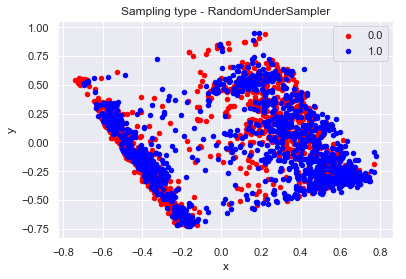


Classification report of fold 1

              precision    recall  f1-score   support

         0.0       0.99      0.63      0.77      7382
         1.0       0.08      0.83      0.15       300

   micro avg       0.64      0.64      0.64      7682
   macro avg       0.54      0.73      0.46      7682
weighted avg       0.95      0.64      0.74      7682


[[4635 2747]
 [  50  250]]

accuracy: 0.6359021088258267
precision: 0.08341675008341674
recall: 0.8333333333333334
f1: 0.15165301789505609
auc: 0.7306059785062766
mcc: 0.18316818272230076
-----------------------------------------------------


Training fold 2


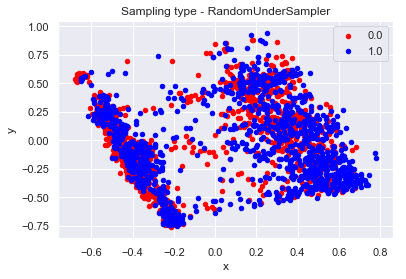


Classification report of fold 2

              precision    recall  f1-score   support

         0.0       0.99      0.64      0.78      7381
         1.0       0.09      0.83      0.16       300

   micro avg       0.65      0.65      0.65      7681
   macro avg       0.54      0.74      0.47      7681
weighted avg       0.95      0.65      0.75      7681


[[4714 2667]
 [  50  250]]

accuracy: 0.6462700169248796
precision: 0.08570449091532396
recall: 0.8333333333333334
f1: 0.1554243083618278
auc: 0.736000090321998
mcc: 0.18841102138422594
-----------------------------------------------------


Training fold 3


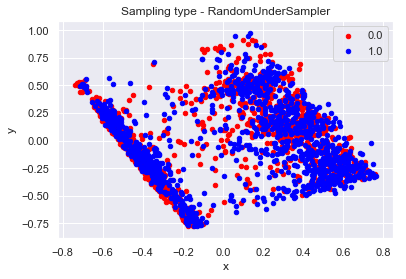


Classification report of fold 3

              precision    recall  f1-score   support

         0.0       0.99      0.64      0.77      7381
         1.0       0.09      0.86      0.16       300

   micro avg       0.64      0.64      0.64      7681
   macro avg       0.54      0.75      0.47      7681
weighted avg       0.96      0.64      0.75      7681


[[4687 2694]
 [  41  259]]

accuracy: 0.6439265720609295
precision: 0.08770741618692855
recall: 0.8633333333333333
f1: 0.1592376268060252
auc: 0.7491710698640653
mcc: 0.1984610959007103
-----------------------------------------------------


Training fold 4


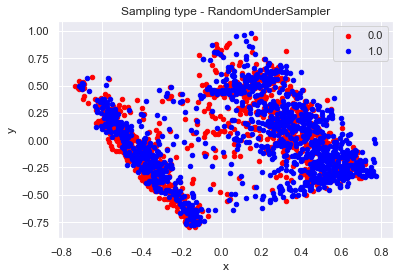


Classification report of fold 4

              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      7381
         1.0       0.09      0.81      0.16       300

   micro avg       0.67      0.67      0.67      7681
   macro avg       0.54      0.74      0.48      7681
weighted avg       0.95      0.67      0.77      7681


[[4940 2441]
 [  57  243]]

accuracy: 0.6747819294362714
precision: 0.0905365126676602
recall: 0.81
f1: 0.1628686327077748
auc: 0.739643002303211
mcc: 0.1947453277758575
-----------------------------------------------------


Training fold 5


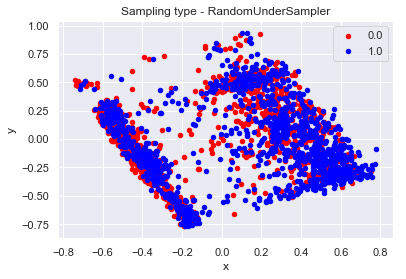


Classification report of fold 5

              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79      7381
         1.0       0.09      0.80      0.16       300

   micro avg       0.66      0.66      0.66      7681
   macro avg       0.54      0.73      0.47      7681
weighted avg       0.95      0.66      0.76      7681


[[4839 2542]
 [  59  241]]

accuracy: 0.661372217159224
precision: 0.08659719726913402
recall: 0.8033333333333333
f1: 0.15634122607849496
auc: 0.729467777627241
mcc: 0.18497112658821968
-----------------------------------------------------


-----------------------------------------------------
Done right mean of scores 5-fold:
-----------------------------------------------------
accuracy: 0.6524505688814262
precision: 0.0867924734244927
recall: 0.8286666666666667
f1: 0.1571049623698358
auc: 0.7369775837245583
mcc: 0.18995135087426282

Training time of RandomForestClassifier is 0.0797 minutes


-----------------------------------

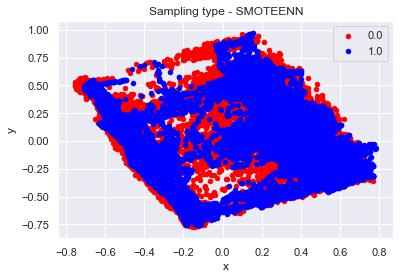


Classification report of fold 1

              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7382
         1.0       0.11      0.71      0.20       300

   micro avg       0.78      0.78      0.78      7682
   macro avg       0.55      0.74      0.53      7682
weighted avg       0.95      0.78      0.84      7682


[[5742 1640]
 [  87  213]]

accuracy: 0.7751887529289248
precision: 0.1149487317862925
recall: 0.71
f1: 0.19786344635392478
auc: 0.7439189921430507
mcc: 0.2208963414506903
-----------------------------------------------------


Training fold 2


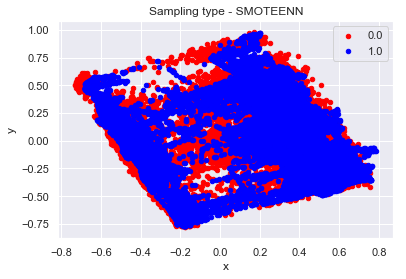


Classification report of fold 2

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      7381
         1.0       0.11      0.67      0.19       300

   micro avg       0.78      0.78      0.78      7681
   macro avg       0.55      0.72      0.53      7681
weighted avg       0.95      0.78      0.84      7681


[[5756 1625]
 [  99  201]]

accuracy: 0.7755500585861216
precision: 0.11007667031763417
recall: 0.67
f1: 0.18908748824082783
auc: 0.7249200650318385
mcc: 0.20472109216063766
-----------------------------------------------------


Training fold 3


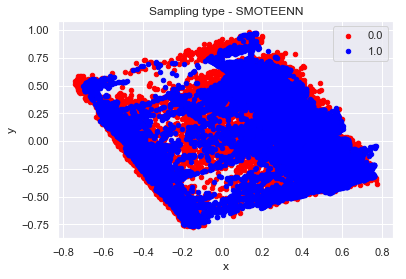


Classification report of fold 3

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      7381
         1.0       0.11      0.70      0.19       300

   micro avg       0.77      0.77      0.77      7681
   macro avg       0.55      0.73      0.53      7681
weighted avg       0.95      0.77      0.84      7681


[[5681 1700]
 [  90  210]]

accuracy: 0.7669574274183049
precision: 0.1099476439790576
recall: 0.7
f1: 0.19004524886877827
auc: 0.7348394526486925
mcc: 0.210512100356494
-----------------------------------------------------


Training fold 4


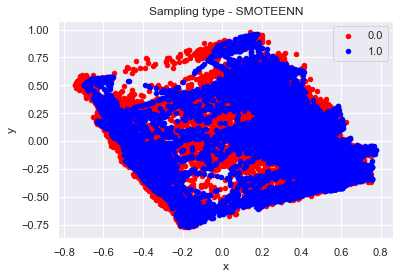


Classification report of fold 4

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      7381
         1.0       0.10      0.68      0.18       300

   micro avg       0.76      0.76      0.76      7681
   macro avg       0.54      0.72      0.52      7681
weighted avg       0.95      0.76      0.83      7681


[[5650 1731]
 [  97  203]]

accuracy: 0.7620101549277438
precision: 0.10496380558428128
recall: 0.6766666666666666
f1: 0.18173679498657117
auc: 0.7210727995303257
mcc: 0.19734889687924503
-----------------------------------------------------


Training fold 5


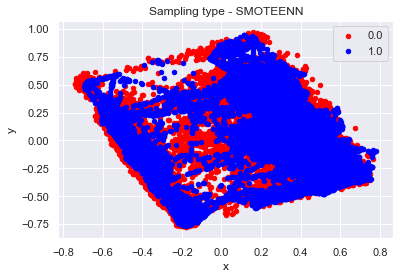


Classification report of fold 5

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      7381
         1.0       0.11      0.69      0.20       300

   micro avg       0.78      0.78      0.78      7681
   macro avg       0.55      0.74      0.53      7681
weighted avg       0.95      0.78      0.85      7681


[[5777 1604]
 [  92  208]]

accuracy: 0.7791954172633772
precision: 0.11479028697571744
recall: 0.6933333333333334
f1: 0.19696969696969696
auc: 0.7380093031657861
mcc: 0.21721059591997924
-----------------------------------------------------


-----------------------------------------------------
Done right mean of scores 5-fold:
-----------------------------------------------------
accuracy: 0.7717803622248944
precision: 0.11094542772859661
recall: 0.6900000000000001
f1: 0.1911405350839598
auc: 0.7325521225039388
mcc: 0.21013780535340926

Training time of LogisticRegression is 0.5948 minutes


------------------------------------

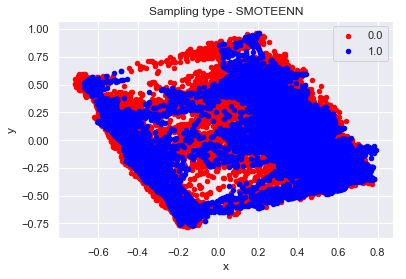


Classification report of fold 1

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      7382
         1.0       0.14      0.54      0.23       300

   micro avg       0.86      0.86      0.86      7682
   macro avg       0.56      0.70      0.57      7682
weighted avg       0.95      0.86      0.89      7682


[[6411  971]
 [ 138  162]]

accuracy: 0.8556365529809945
precision: 0.14298323036187113
recall: 0.54
f1: 0.22609909281228194
auc: 0.7042319154700625
mcc: 0.2231509827892579
-----------------------------------------------------


Training fold 2


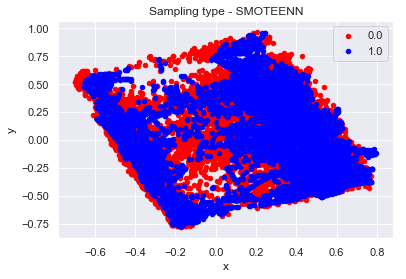


Classification report of fold 2

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      7381
         1.0       0.14      0.50      0.22       300

   micro avg       0.86      0.86      0.86      7681
   macro avg       0.56      0.69      0.57      7681
weighted avg       0.94      0.86      0.90      7681


[[6481  900]
 [ 149  151]]

accuracy: 0.8634292409842469
precision: 0.14367269267364416
recall: 0.5033333333333333
f1: 0.22353811991117695
auc: 0.6906993180689156
mcc: 0.21500038792065573
-----------------------------------------------------


Training fold 3


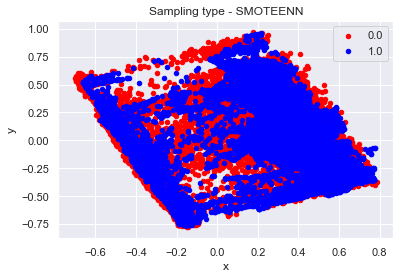


Classification report of fold 3

              precision    recall  f1-score   support

         0.0       0.98      0.86      0.91      7381
         1.0       0.13      0.51      0.20       300

   micro avg       0.84      0.84      0.84      7681
   macro avg       0.55      0.69      0.56      7681
weighted avg       0.94      0.84      0.89      7681


[[6331 1050]
 [ 146  154]]

accuracy: 0.8442911079286551
precision: 0.12790697674418605
recall: 0.5133333333333333
f1: 0.2047872340425532
auc: 0.6855380933026238
mcc: 0.19773389575650133
-----------------------------------------------------


Training fold 4


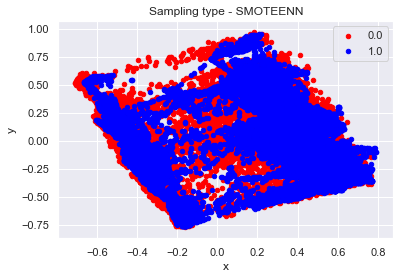


Classification report of fold 4

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      7381
         1.0       0.13      0.50      0.21       300

   micro avg       0.85      0.85      0.85      7681
   macro avg       0.56      0.68      0.57      7681
weighted avg       0.94      0.85      0.89      7681


[[6408  973]
 [ 150  150]]

accuracy: 0.8537950787657858
precision: 0.13357079252003562
recall: 0.5
f1: 0.21082220660576248
auc: 0.684087522015987
mcc: 0.201881718586923
-----------------------------------------------------


Training fold 5


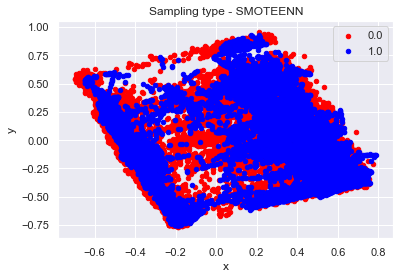


Classification report of fold 5

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      7381
         1.0       0.14      0.52      0.22       300

   micro avg       0.86      0.86      0.86      7681
   macro avg       0.56      0.69      0.57      7681
weighted avg       0.95      0.86      0.89      7681


[[6439  942]
 [ 145  155]]

accuracy: 0.8584819684936857
precision: 0.14129443938012762
recall: 0.5166666666666667
f1: 0.2219040801717967
auc: 0.6945208418010206
mcc: 0.21541013908253456
-----------------------------------------------------


-----------------------------------------------------
Done right mean of scores 5-fold:
-----------------------------------------------------
accuracy: 0.8551267898306737
precision: 0.13788562633597293
recall: 0.5146666666666666
f1: 0.21743014670871424
auc: 0.6918155381317218
mcc: 0.2106354248271745

Training time of XGBClassifier is 0.5453 minutes


------------------------------------------

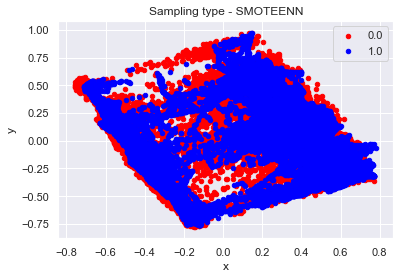


Classification report of fold 1

              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      7382
         1.0       0.11      0.74      0.19       300

   micro avg       0.75      0.75      0.75      7682
   macro avg       0.55      0.75      0.52      7682
weighted avg       0.95      0.75      0.82      7682


[[5523 1859]
 [  77  223]]

accuracy: 0.7479822962770112
precision: 0.10710854947166186
recall: 0.7433333333333333
f1: 0.18723761544920234
auc: 0.7457522803215026
mcc: 0.21421053391543904
-----------------------------------------------------


Training fold 2


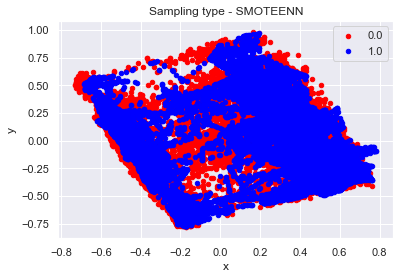


Classification report of fold 2

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      7381
         1.0       0.10      0.69      0.18       300

   micro avg       0.75      0.75      0.75      7681
   macro avg       0.54      0.72      0.52      7681
weighted avg       0.95      0.75      0.83      7681


[[5564 1817]
 [  92  208]]

accuracy: 0.7514646530399688
precision: 0.10271604938271604
recall: 0.6933333333333334
f1: 0.17892473118279567
auc: 0.7235803639976517
mcc: 0.1966141048621243
-----------------------------------------------------


Training fold 3


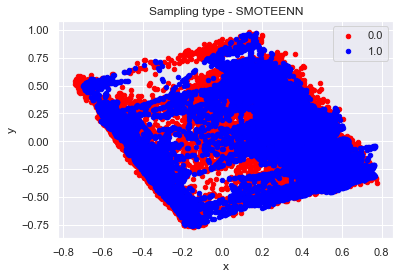


Classification report of fold 3

              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      7381
         1.0       0.11      0.73      0.18       300

   micro avg       0.75      0.75      0.75      7681
   macro avg       0.55      0.74      0.52      7681
weighted avg       0.95      0.75      0.82      7681


[[5506 1875]
 [  80  220]]

accuracy: 0.7454758494987632
precision: 0.10501193317422435
recall: 0.7333333333333333
f1: 0.1837160751565762
auc: 0.7396513570880188
mcc: 0.20849019666155505
-----------------------------------------------------


Training fold 4


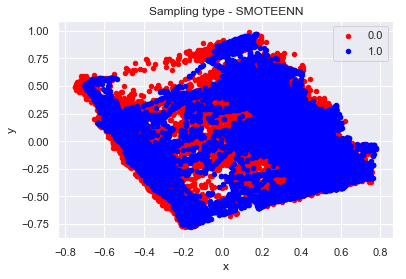


Classification report of fold 4

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      7381
         1.0       0.10      0.70      0.17       300

   micro avg       0.74      0.74      0.74      7681
   macro avg       0.54      0.72      0.51      7681
weighted avg       0.95      0.74      0.82      7681


[[5472 1909]
 [  91  209]]

accuracy: 0.7396172373388882
precision: 0.09867799811142587
recall: 0.6966666666666667
f1: 0.1728701406120761
auc: 0.7190148128076593
mcc: 0.18989092352042877
-----------------------------------------------------


Training fold 5


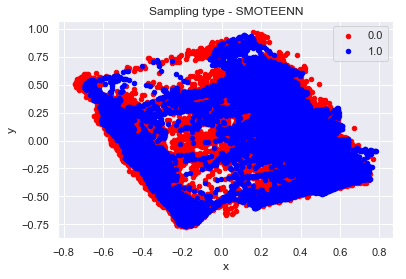


Classification report of fold 5

              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      7381
         1.0       0.11      0.75      0.19       300

   micro avg       0.75      0.75      0.75      7681
   macro avg       0.55      0.75      0.52      7681
weighted avg       0.95      0.75      0.83      7681


[[5534 1847]
 [  74  226]]

accuracy: 0.749902356464002
precision: 0.10902074288470816
recall: 0.7533333333333333
f1: 0.1904761904761905
auc: 0.7515481190443933
mcc: 0.2195662812543105
-----------------------------------------------------


-----------------------------------------------------
Done right mean of scores 5-fold:
-----------------------------------------------------
accuracy: 0.7468884785237266
precision: 0.10450705460494725
recall: 0.724
f1: 0.18264495057536814
auc: 0.7359093866518451
mcc: 0.20575440804277156

Training time of LinearSVC is 0.6288 minutes


-----------------------------------------------------
Traini

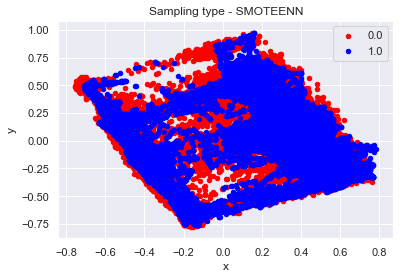


Classification report of fold 1

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86      7382
         1.0       0.11      0.71      0.19       300

   micro avg       0.76      0.76      0.76      7682
   macro avg       0.55      0.74      0.52      7682
weighted avg       0.95      0.76      0.83      7682


[[5621 1761]
 [  86  214]]

accuracy: 0.7595678208799792
precision: 0.10835443037974683
recall: 0.7133333333333334
f1: 0.18813186813186814
auc: 0.7373900478641742
mcc: 0.2104518099717311
-----------------------------------------------------


Training fold 2


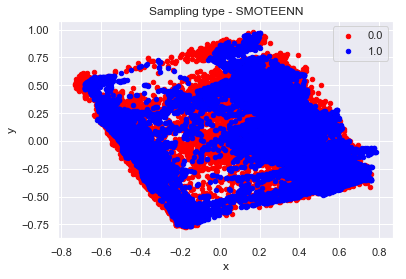


Classification report of fold 2

              precision    recall  f1-score   support

         0.0       0.99      0.77      0.86      7381
         1.0       0.11      0.72      0.19       300

   micro avg       0.76      0.76      0.76      7681
   macro avg       0.55      0.74      0.53      7681
weighted avg       0.95      0.76      0.84      7681


[[5649 1732]
 [  85  215]]

accuracy: 0.7634422601223799
precision: 0.11042629686697483
recall: 0.7166666666666667
f1: 0.19136626613262128
auc: 0.7410050580318837
mcc: 0.2146656535247481
-----------------------------------------------------


Training fold 3


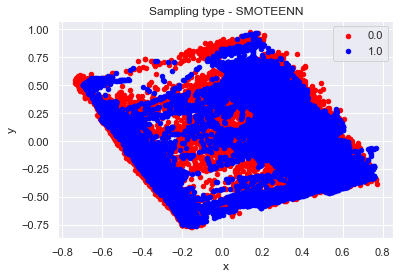


Classification report of fold 3

              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      7381
         1.0       0.11      0.73      0.19       300

   micro avg       0.75      0.75      0.75      7681
   macro avg       0.55      0.74      0.52      7681
weighted avg       0.95      0.75      0.83      7681


[[5566 1815]
 [  80  220]]

accuracy: 0.7532873323785966
precision: 0.10810810810810811
recall: 0.7333333333333333
f1: 0.18843683083511778
auc: 0.7437158469945355
mcc: 0.21398303894077775
-----------------------------------------------------


Training fold 4


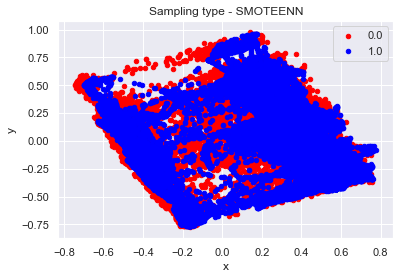


Classification report of fold 4

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.85      7381
         1.0       0.10      0.69      0.18       300

   micro avg       0.75      0.75      0.75      7681
   macro avg       0.54      0.72      0.52      7681
weighted avg       0.95      0.75      0.83      7681


[[5575 1806]
 [  92  208]]

accuracy: 0.7528967582346049
precision: 0.10327706057596822
recall: 0.6933333333333334
f1: 0.17977528089887643
auc: 0.724325520480513
mcc: 0.19761530197056085
-----------------------------------------------------


Training fold 5


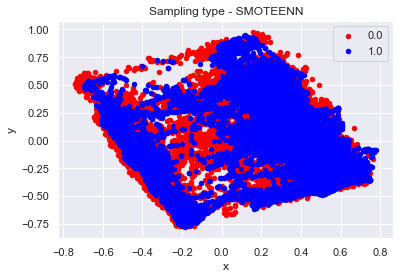


Classification report of fold 5

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      7381
         1.0       0.11      0.72      0.19       300

   micro avg       0.76      0.76      0.76      7681
   macro avg       0.55      0.74      0.52      7681
weighted avg       0.95      0.76      0.83      7681


[[5624 1757]
 [  84  216]]

accuracy: 0.7603176669704466
precision: 0.10947795235681702
recall: 0.72
f1: 0.19005719313682357
auc: 0.7409781872375016
mcc: 0.2137078297149701
-----------------------------------------------------


-----------------------------------------------------
Done right mean of scores 5-fold:
-----------------------------------------------------
accuracy: 0.7579023677172014
precision: 0.107928769657523
recall: 0.7153333333333334
f1: 0.18755348782706144
auc: 0.7374829321217216
mcc: 0.2100847268245576

Training time of SVC is 12.7034 minutes



In [67]:
dfScores, dfScores_detailed = kfold_cross_validation_multiples_models_sampler(models, X_train, y_train, n_splits=5)

### Comparative alternatives

### Metrics

#### Accuracy

 - The accuracy is intuitively the ability of correctly classifier samples. The best value is 1 and the worst value is 0.

#### Precision

  - The precision is intuitively the ability of the classifier not to label as positive a sample
that is negative. The best value is 1 and the worst value is 0.

#### Recall

  - The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.

#### F1

  - The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

#### AUC

  - Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores. The best value is 1 and the worst value is 0.

#### MCC

  - The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.

In [68]:
dfScores.set_index('model', inplace=True)
dfScores_detailed.set_index('model', inplace=True)

In [69]:
def show_bar_plot(name, data):
    
    index = np.arange(len(data.index))
    
    plt.figure(figsize=(8,4))
    plt.bar(index, data)
    plt.ylabel('Cross validation mean score')
    plt.xticks(index, data.index, rotation=30)
    plt.title(name)
    plt.show()

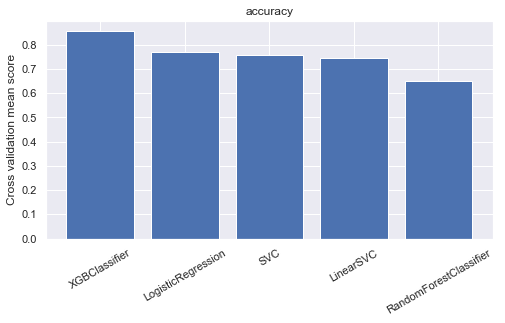

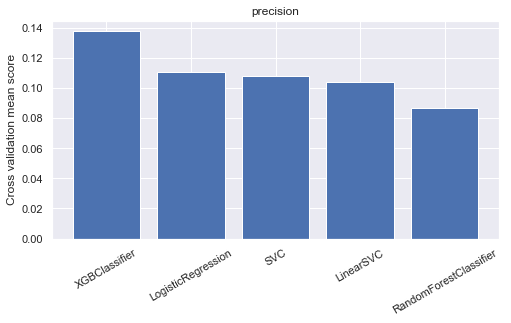

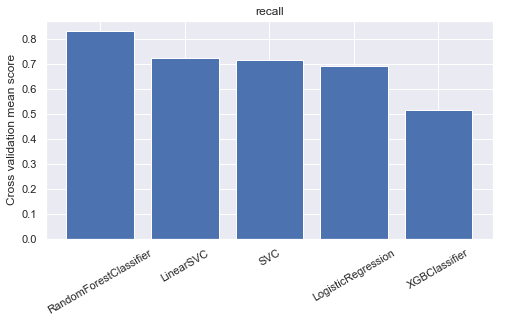

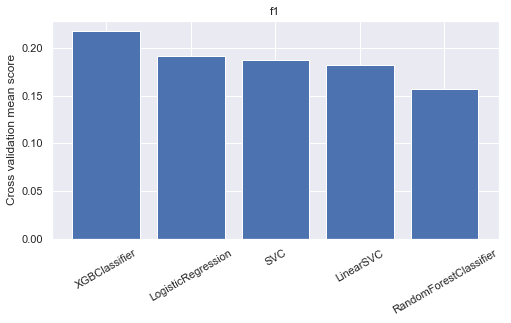

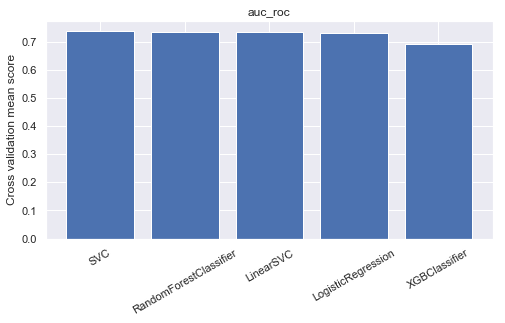

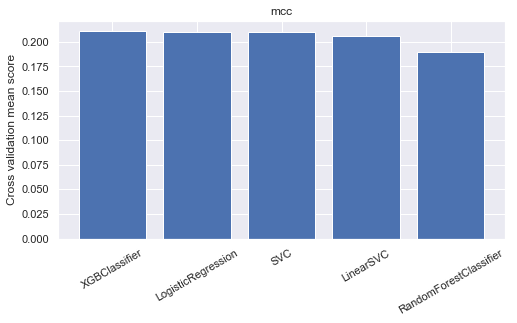

In [70]:
for i, col in enumerate(dfScores.columns):
        show_bar_plot(col, dfScores[col].sort_values(ascending=False))

In [71]:
dfScores.sort_values('auc_roc', ascending=False)

,accuracy,precision,recall,f1,auc_roc,mcc
model,,,,,,
SVC,0.757902,0.107929,0.715333,0.187553,0.737483,0.210085
RandomForestClassifier,0.652451,0.086792,0.828667,0.157105,0.736978,0.189951
LinearSVC,0.746888,0.104507,0.724000,0.182645,0.735909,0.205754
LogisticRegression,0.771780,0.110945,0.690000,0.191141,0.732552,0.210138
XGBClassifier,0.855127,0.137886,0.514667,0.217430,0.691816,0.210635


### Best model score in training

In [72]:
dfScores.sort_values('auc_roc', ascending=False).head(1)

,accuracy,precision,recall,f1,auc_roc,mcc
model,,,,,,
SVC,0.757902,0.107929,0.715333,0.187553,0.737483,0.210085


The combinacion of classifier SVC and hybrid sampling SMOTEENN obtained the best scores. SMOTEENN combine over and under-sampling using SMOTE and Edited Nearest Neighbours.

### Testing chosen model (SVC)

In [73]:
index_best_model = dfScores.reset_index().sort_values('auc_roc', ascending=False).head(1).index.values[0]

modelChosen = models[index_best_model][0]

modelChosen

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

-----------------------------------------------------
Evaluating model test SVC
-----------------------------------------------------


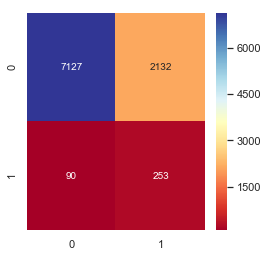

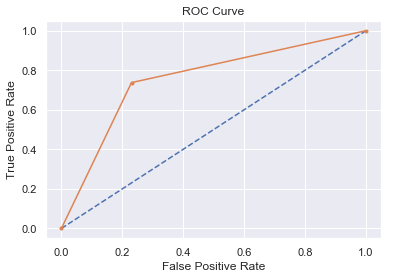

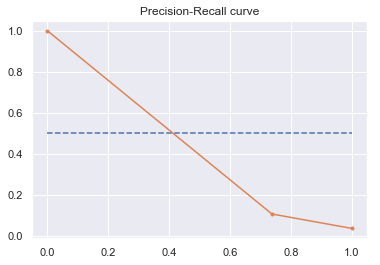

-----------------------------------------------------
Classification Report of SVC
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      9259
         1.0       0.11      0.74      0.19       343

   micro avg       0.77      0.77      0.77      9602
   macro avg       0.55      0.75      0.53      9602
weighted avg       0.96      0.77      0.84      9602


accuracy:  0.76859
precision: 0.10608
recall:    0.73761
f1:        0.18548
auc:       0.75367
mcc:       0.21793
-----------------------------------------------------



In [75]:
name = modelChosen.__class__.__name__

pred = modelChosen.predict(X_test)

print('-----------------------------------------------------')
print("Evaluating model test {}".format(name))
print('-----------------------------------------------------')

show_confusion_matrix(y_test, pred)
show_roc_curve(y_test, pred)
show_precision_recall_curve(y_test, pred)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
auc = roc_auc_score(y_test, pred)
mcc = matthews_corrcoef(y_test, pred)

print('-----------------------------------------------------')
print('Classification Report of {}'.format(name))
print('-----------------------------------------------------')
print(classification_report(y_test, pred))   
print()
print("accuracy:  %.5f" %accuracy)
print("precision: %.5f" %precision)
print("recall:    %.5f" %recall)
print("f1:        %.5f" %f1)
print("auc:       %.5f" %auc)
print("mcc:       %.5f" %mcc)
print('-----------------------------------------------------')
print()